In [6]:
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.stattools import jarque_bera  
from statsmodels.iolib.table import SimpleTable
import numpy as np
import statsmodels.api as st
from sklearn.metrics import r2_score
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
import pandas as pd

In [12]:
start = '2016'
end = datetime(2021, 10, 1)
moex = web.DataReader('GAZP', 'moex', start=start, end=end)

In [14]:
gas_wap = moex['CLOSE']
close_gas = moex['CLOSE']

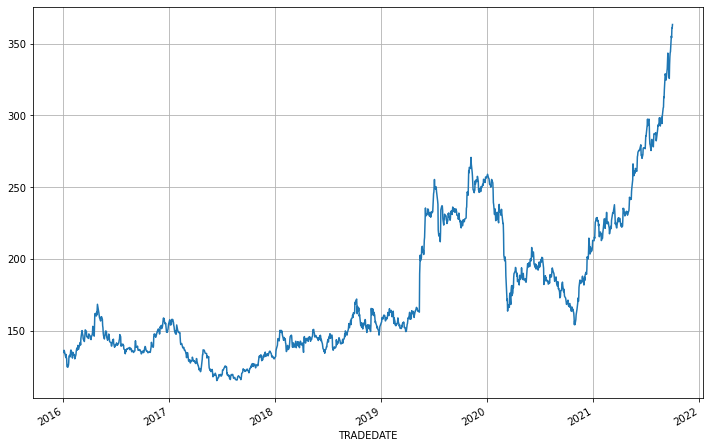

In [15]:
close_gas.plot(grid=True, figsize=(12,8))
# Show the plot
plt.show()

### Rolling window estimations

In [16]:
# наивный прогноз по среднему из n - кол-ву дней
def moving_average(series, n):
    """
     Будущее значение переменной зависит от среднего n её предыдущих значений 
    """
    return np.average(series[-n:])

moving_average(gas_wap, 30)

328.2636666666666

Скользящее среднее в пандасе: pd.DataFrame.rolling(window).mean()

In [17]:
n = 7
rolling_mean = gas_wap.rolling(n).mean()

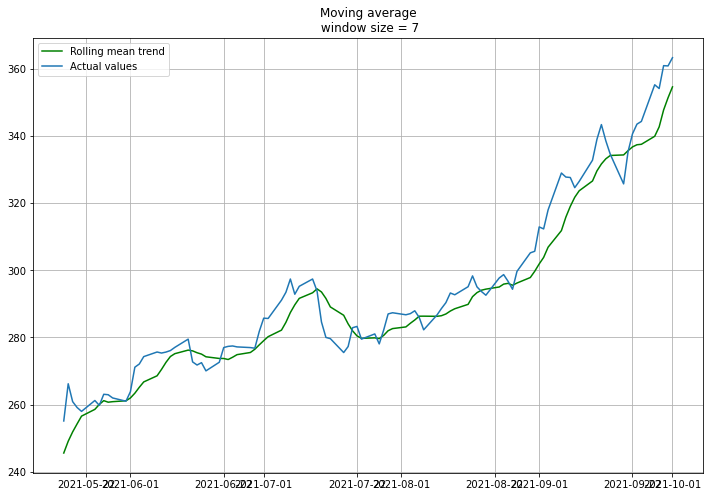

In [18]:
plt.figure(figsize=(12, 8))
plt.title(f'Moving average\n window size = {n}')
plt.plot(rolling_mean[-100:], "g", label="Rolling mean trend")
plt.plot(gas_wap[-100:], label="Actual values")
plt.legend(loc="upper left")
plt.grid(True)

### Exponential smoothing

$\hat{y}_t = \alpha  y_t + (1 - \alpha)  \hat{y}_{t-1}$

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [68]:
model = SimpleExpSmoothing(close_gas[-80:])

# model alpha = 0.2
model_fit_02 = model.fit(smoothing_level=0.2, optimized=False)
pred_02 = model_fit_02.forecast(3).rename('alpha=0.2')

# model alpha = 0.5
model_fit_05 = model.fit(smoothing_level=0.5, optimized=False)
pred_05 = model_fit_05.forecast(3).rename('alpha=0.5')

# model alpha = 0.8
model_fit_08 = model.fit(smoothing_level=0.8, optimized=False)
pred_08 = model_fit_08.forecast(3).rename('alpha=0.8')

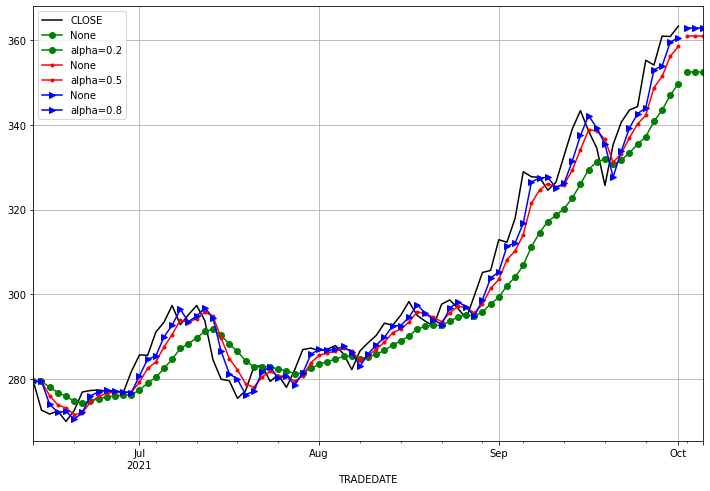

In [69]:
close_gas[-80:].plot(legend=True, grid=True, figsize=(12,8), color='black')

# plot for alpha = 0.2
model_fit_02.fittedvalues.plot(marker='o',legend=True, color='green')
pred_02.plot(marker='o',legend=True, color='green')

# plot for alpha = 0.5
model_fit_05.fittedvalues.plot(marker='.',legend=True, color='red')
pred_05.plot(marker='.',legend=True, color='red')

# plot for alpha = 0.8
model_fit_08.fittedvalues.plot(marker='>', legend=True, color='blue')
pred_08.plot(marker='>', legend=True, color='blue')

plt.grid()

### Holt’s Exponential Smoothing

$\hat{y}_{t+d} = a_t + d b_t$;

$a_t = \alpha_1 y_t + (1-\alpha_1)(a_{t-1} - b_{t-1})$;

$b_t = \alpha_2(a_t - a_{t-1})+(1-\alpha_2)b_{t-1}$,

где $a_t$ - прогноз, очищенный от тренда(по сути эксп. сглаживание), $b_t$ - параметр линейного тренда.

In [70]:
from statsmodels.tsa.holtwinters import Holt

In [77]:
model = Holt(close_gas[-30:])

# model alpha_1 = 0.3, alpha_2 = 0.05
model_fit_03_005 = model.fit(smoothing_level=0.3, smoothing_slope=0.05, optimized=False)
pred_03_005 = model_fit_03_005.forecast(3).rename('alpha_1=0.3, alpha_2=0.05')

# model opt=True
model_fit_opt = model.fit(optimized=True)
pred_opt = model_fit_opt.forecast(3).rename('opt=True')

# model alpha_1 = 0.3, alpha_2 = 0.2
model_fit_03_02 = model.fit(smoothing_level=0.3, smoothing_slope=0.2, optimized=False)
pred_03_02 = model_fit_03_02.forecast(3).rename('alpha_1=0.3, alpha_2=0.2')

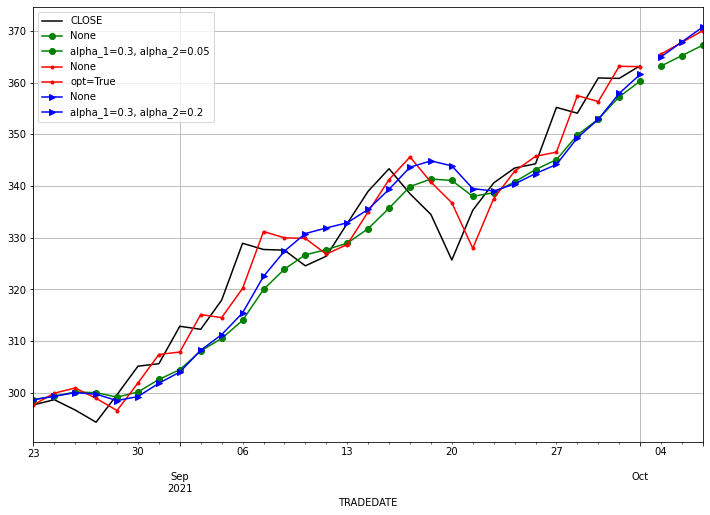

In [78]:
close_gas[-30:].plot(legend=True, grid=True, figsize=(12,8), color='black')

# plot for alpha_1 = 0.3, alpha_2 = 0.05
model_fit_03_005.fittedvalues.plot(marker='o',legend=True, color='green')
pred_03_005.plot(marker='o',legend=True, color='green')

# plot for model opt=True
model_fit_opt.fittedvalues.plot(marker='.',legend=True, color='red')
pred_opt.plot(marker='.',legend=True, color='red')

# plot for alpha_1 = 0.3, alpha_2 = 0.2
model_fit_03_02.fittedvalues.plot(marker='>', legend=True, color='blue')
pred_03_02.plot(marker='>', legend=True, color='blue')

plt.grid()

In [79]:
model_fit_opt.summary()

Dep. Variable:,CLOSE,No. Observations:,30
Model:,Holt,SSE,656.915
Optimized:,True,AIC,100.591
Trend:,Additive,BIC,106.196
Seasonal:,None,AICC,104.243
Seasonal Periods:,None,Date:,"Fri, 22 Oct 2021"
Box-Cox:,False,Time:,01:29:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True
